In [1]:
import os
import glob
import numpy as np
import pandas as pd


In [2]:

# ============================================================
# 設定（ここだけ自分の環境に合わせて変える）
# ============================================================
base_dir = r".\\data\\test_3_SKAB"  # ← この下に data/ がある想定
data_dir = os.path.join(base_dir, "data")

normal_csv = os.path.join(data_dir, "anomaly-free", "anomaly-free.csv")
other_dir  = os.path.join(data_dir, "other")

# 参照（正常）として使う点数、テストで「最初に流す正常点数」
# ※ 長すぎると計算が重くなるので、まずはこのくらいから推奨
N_REF = 6000
N_TEST_NORMAL_PREFIX = 3000

# 出力ファイル
out_npz = os.path.join(base_dir, "mmd_dataset_from_anomalyfree_other.npz")



In [3]:

# ============================================================
# 1) CSV読み込み（壊れにくい）
# ============================================================
def read_csv_robust(path):
    """
    CSV（;区切り）を読む。
    """
    return pd.read_csv(path, sep=";")


def list_csvs(dir_path):
    files = sorted(glob.glob(os.path.join(dir_path, "*.csv")))
    if len(files) == 0:
        raise FileNotFoundError(f"CSVが見つかりません: {dir_path}")
    return files


# ============================================================
# 2) 「使う列」を決める（全ファイルで共通の数値列）
# ============================================================
def numeric_common_columns(dfs, drop_like=("time", "timestamp", "date")):
    """
    複数DataFrameに共通して存在する「数値列」だけを返す。
    さらに time/timestamp/date っぽい列名は落とす（必要なら後で外す条件を変える）。
    """
    num_sets = []
    for df in dfs:
        num_cols = df.select_dtypes(include=[np.number]).columns
        num_sets.append(set(num_cols))

    common = set.intersection(*num_sets)
    common = [c for c in sorted(common) if not any(k in c.lower() for k in drop_like)]
    if len(common) == 0:
        raise ValueError(
            "共通の数値列が0です。"
            "CSVの列名がファイルごとに違う/数値に読めていない可能性があります。"
        )
    return common


def to_array(df, feature_cols):
    """
    指定列を (N, D) の float32 配列にする。
    NaN/inf は線形補間→残りは前後埋め→それでも残るなら0埋め。
    """
    x = df[feature_cols].copy()
    x = x.replace([np.inf, -np.inf], np.nan)

    # 時系列だと欠損が混じりやすいので、補間→埋め
    x = x.interpolate(limit_direction="both")
    x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)

    return x.to_numpy(dtype=np.float32)



In [4]:

# ============================================================
# 3) 正常/異常データをロードして整形
# ============================================================
# 正常（1ファイル）
df_normal = read_csv_robust(normal_csv)

# 異常（other配下の複数ファイル）
other_files = list_csvs(other_dir)
dfs_other = [read_csv_robust(p) for p in other_files]

# 全体で共通の数値列を採用（特徴量次元 D）
feature_cols = numeric_common_columns([df_normal] + dfs_other)

# 配列化
X_normal_all = to_array(df_normal, feature_cols)  # (Nn, D)
X_other_all_list = [to_array(df, feature_cols) for df in dfs_other]
X_other_all = np.vstack(X_other_all_list)         # (Ne, D)

print("==== 読み込み結果 ====")
print("normal:", X_normal_all.shape, "from", normal_csv)
print("other :", X_other_all.shape, "from", len(other_files), "files")
print("features D =", len(feature_cols))
print("feature_cols =", feature_cols)



==== 読み込み結果 ====
normal: (9405, 8) from .\\data\\test_3_SKAB\data\anomaly-free\anomaly-free.csv
other : (14929, 8) from 14 files
features D = 8
feature_cols = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']


C:\Users\tsenz\AppData\Local\Temp\ipykernel_16140\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\tsenz\AppData\Local\Temp\ipykernel_16140\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\tsenz\AppData\Local\Temp\ipykernel_16140\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\tsenz\AppData\Local\Temp\ipykernel_16140\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill()

In [5]:

# ============================================================
# 4) 学習用（参照）とテスト用（逐次）を作る
#    ここでは「最初は正常を流して、その後に異常を流す」構成にする
#    → 変化点 cp_index が明確になる
# ============================================================
# 参照X_refは正常から先頭N_REF点（足りなければ全部）
N_REF_eff = min(N_REF, X_normal_all.shape[0])
X_ref = X_normal_all[:N_REF_eff].copy()

# テストの正常プレフィックス（最初に流す正常区間）
# 参照に使った部分と同じ箇所を避けたいなら、後ろから取るなども可。
# ここでは「参照の続き」から取る（重複を減らす）
start = N_REF_eff
end = min(start + N_TEST_NORMAL_PREFIX, X_normal_all.shape[0])
X_test_normal = X_normal_all[start:end].copy()

# 異常側は全部使うと長くなるので、まずは全部でOK（重ければ後で間引く）
X_test_error = X_other_all.copy()

# 逐次ストリーム：正常→異常
X_stream = np.vstack([X_test_normal, X_test_error]).astype(np.float32)
y_stream = np.concatenate([
    np.zeros(X_test_normal.shape[0], dtype=np.int32),  # 0=正常
    np.ones(X_test_error.shape[0], dtype=np.int32)     # 1=異常
])
cp_index = X_test_normal.shape[0]  # このインデックスから後が異常（真の変化点）

print("\n==== 逐次テスト構成 ====")
print("X_ref        :", X_ref.shape)
print("X_test_normal:", X_test_normal.shape)
print("X_test_error :", X_test_error.shape)
print("X_stream     :", X_stream.shape)
print("cp_index     :", cp_index, "(この位置から異常が始まる)")




==== 逐次テスト構成 ====
X_ref        : (6000, 8)
X_test_normal: (3000, 8)
X_test_error : (14929, 8)
X_stream     : (17929, 8)
cp_index     : 3000 (この位置から異常が始まる)


In [ ]:

# ============================================================
# 5) 標準化（参照X_refで平均・標準偏差を作り、すべてに適用）
#    MMDは距離に敏感なので、スケール合わせはほぼ必須
# ============================================================
mu = X_ref.mean(axis=0)
sd = X_ref.std(axis=0) + 1e-12

X_ref_z = (X_ref - mu) / sd
X_stream_z = (X_stream - mu) / sd

X_ref_z = X_ref
X_stream_z = X_stream

print("\n==== 標準化後 ====")
print("X_ref_z    :", X_ref_z.shape)
print("X_stream_z :", X_stream_z.shape)


# ============================================================
# 6) 保存（このnpzをそのままMMDの実験に使える）
# ============================================================
np.savez(
    out_npz,
    X_ref=X_ref_z,                 # 参照（標準化済み）
    X_stream=X_stream_z,           # 逐次ストリーム（標準化済み）
    y_stream=y_stream,             # 0=正常, 1=異常
    cp_index=np.int32(cp_index),   # 真の変化点（X_stream内）
    feature_cols=np.array(feature_cols, dtype=object),
    normal_file=np.array([normal_csv], dtype=object),
    other_files=np.array(other_files, dtype=object),
)

print("\nSaved:", out_npz)



==== 標準化後 ====
X_ref_z    : (6000, 8)
X_stream_z : (17929, 8)

Saved: .\\data\\test_3_SKAB\mmd_dataset_from_anomalyfree_other.npz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

from alibi_detect.cd import MMDDriftOnline

# ============================================================
# 0) さっき作った npz を読み込む
# ============================================================
npz_path = r".\\data\\test_3_SKAB\mmd_dataset_from_anomalyfree_other.npz"  # ←自分の保存先に変更
data = np.load(npz_path, allow_pickle=True)

X_ref    = data["X_ref"].astype(np.float32)       # (N_ref, D)  標準化済み
X_stream = data["X_stream"].astype(np.float32)    # (N_stream, D) 標準化済み
y_stream = data["y_stream"].astype(np.int32)      # 0=正常, 1=異常
cp_index = int(data["cp_index"])                  # 真の変化点（このindexから異常が始まる）

print("X_ref shape   =", X_ref.shape)
print("X_stream shape=", X_stream.shape)
print("cp_index      =", cp_index)

X_stream


d:\tsenz\testPython\mystudy_alibi\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


X_ref shape   = (6000, 8)
X_stream shape= (17929, 8)
cp_index      = 3000


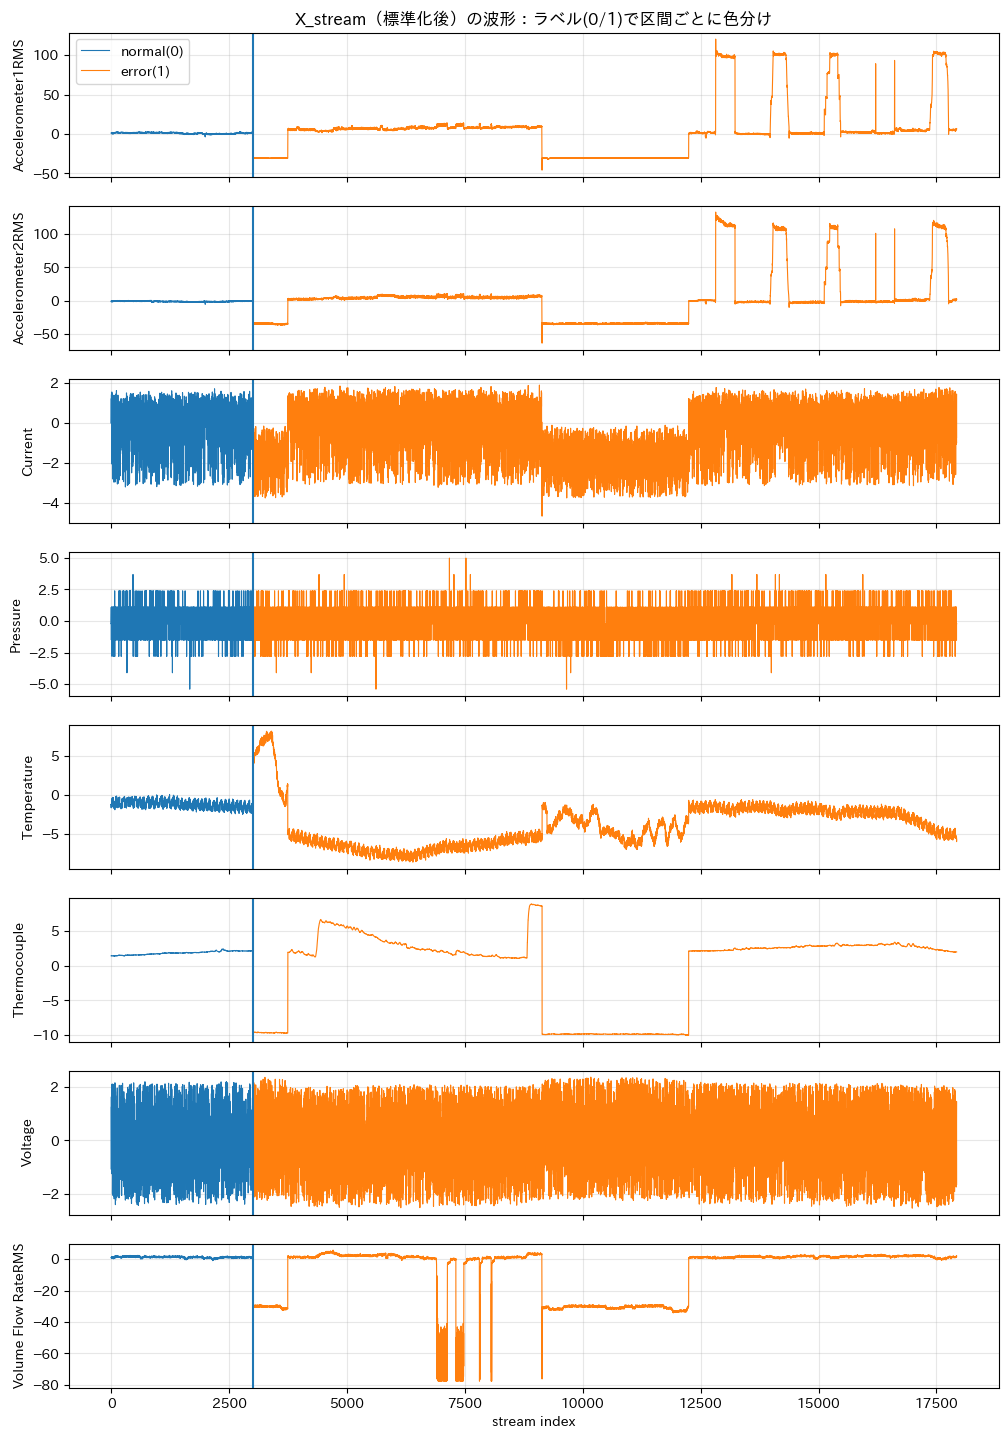

In [10]:

import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# X_stream を「波形（時系列）」として可視化
#  - カラム（センサ）ごとに別プロット（縦に並べる）
#  - ラベル y_stream（0=正常, 1=異常）で線色を切り替えて表示
#  - 真の変化点 cp_index に縦線
#
# 前提：
#   X_stream_z : (N, D)  標準化済みストリーム
#   y_stream   : (N,)    0/1 ラベル
#   cp_index   : int     変化点（このindexから異常が始まる）
#   feature_cols: list   列名（なければ f0,f1,... で代替）
# ============================================================

X_plot = X_stream_z  # 標準化後を見たいならこれ。標準化前なら X_stream を指定

N, D = X_plot.shape
t = np.arange(N)

# 列名の用意（なければ f0,f1,...）
if "feature_cols" in globals() and feature_cols is not None and len(feature_cols) == D:
    names = list(feature_cols)
else:
    names = [f"f{i}" for i in range(D)]

# 連続区間（ラベルが同じ区間）ごとに線を引くための境界を作る
y = y_stream.astype(int)
change = np.where(np.diff(y) != 0)[0] + 1
bounds = np.r_[0, change, N]

fig, axes = plt.subplots(D, 1, figsize=(12, max(3, 2.2*D)), sharex=True)

# D=1 のとき axes が配列にならない対策
if D == 1:
    axes = [axes]

for j in range(D):
    ax = axes[j]

    # ラベルごとに区間を分けてプロット（色はmatplotlibの自動色に任せる）
    for b0, b1 in zip(bounds[:-1], bounds[1:]):
        lab = int(y[b0])
        label_text = "normal(0)" if lab == 0 else "error(1)"

        # 凡例が同じラベルで増殖しないように最初の1回だけ付ける
        use_label = label_text if (j == 0 and ((lab == 0 and b0 == bounds[0]) or (lab == 1 and b0 == bounds[1] if len(bounds) > 2 else True))) else None

        ax.plot(t[b0:b1], X_plot[b0:b1, j], linewidth=0.8, label=use_label)

    # 真の変化点
    ax.axvline(cp_index, linewidth=1.5)

    ax.set_ylabel(str(names[j]))
    ax.grid(True, alpha=0.3)

axes[0].set_title("X_stream（標準化後）の波形：ラベル(0/1)で区間ごとに色分け")
axes[-1].set_xlabel("stream index")

# 凡例（上段だけ）
handles, labels = axes[0].get_legend_handles_labels()
if len(handles) > 0:
    axes[0].legend()

plt.show()


In [11]:

# ============================================================
# 1) MMDDriftOnline の設定
#    ert は「誤検知の起きにくさ」の目安（大きいほど誤検知が減る）
#    n_bootstraps は threshold 推定のため（大きいほど安定するが重い）
# ============================================================
window_size  = 50
ert          = 500.0
n_bootstraps = 5000
backend      = "tensorflow"

cd = MMDDriftOnline(
    x_ref=X_ref,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [08:17<00:00,  9.95s/it]


In [12]:

# ============================================================
# 2) 逐次投入して「全時刻のスコア」を保存する
#    score = test_stat - threshold（0より大きいと drift 判定になりやすい）
#
#    k_consec:
#      is_drift==1 が k_consec 回連続したら「確定検知」とみなす（単発誤検知を潰す）
# ============================================================
from tqdm.auto import tqdm
import numpy as np

def stream_mmd_full(cd, X_stream, window_size, k_consec=1):
    cd.reset_state()
    n = X_stream.shape[0]

    test_stat = np.full(n, np.nan, dtype=float)
    threshold = np.full(n, np.nan, dtype=float)
    is_drift  = np.zeros(n, dtype=int)
    time_in   = np.full(n, np.nan, dtype=float)

    consec = 0
    i_detect = None

    for i in tqdm(range(n), desc="MMD streaming", total=n):
        pred = cd.predict(X_stream[i], return_test_stat=True)
        d = pred["data"]

        is_drift[i]  = int(d.get("is_drift", 0))
        test_stat[i] = float(d.get("test_stat", np.nan))
        threshold[i] = float(d.get("threshold", np.nan))
        time_in[i]   = float(d.get("time", np.nan))

        if i < window_size - 1:
            consec = 0
            continue

        consec = consec + 1 if is_drift[i] == 1 else 0
        if i_detect is None and consec >= k_consec:
            i_detect = i

    score = test_stat - threshold
    score[:window_size-1] = np.nan
    return score, test_stat, threshold, is_drift, time_in, i_detect



k_consec = 10
score, ts, th, dr, t_in, i_detect = stream_mmd_full(cd, X_stream, window_size, k_consec=k_consec)


MMD streaming: 100%|██████████| 17929/17929 [02:51<00:00, 104.80it/s]



=== ドリフト検知まとめ ===
真の変化点 cp_index = 3000
cp以降の最初の is_drift==1 : 3000（遅れ 0 サンプル）
k_consec=10 連続で確定した検知 i_detect = 58
確定検知の遅れ = -2942 サンプル
is_drift==1 の総数 = 17915


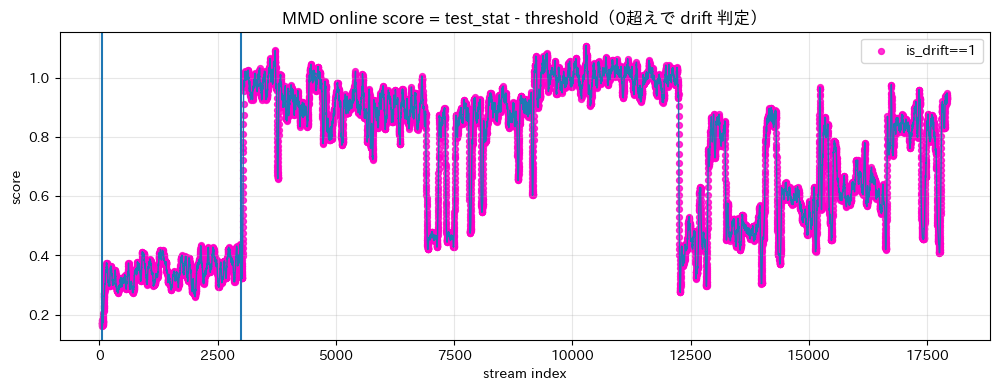

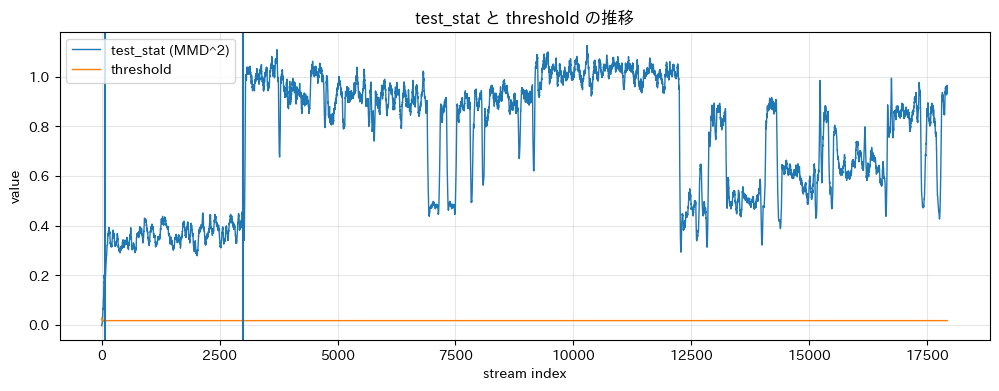

In [14]:

# ============================================================
# 3) 結果の要約（真の変化点 vs 検知）
# ============================================================
idx_drift_all = np.where(dr == 1)[0]

# 「変化点以降で最初に drift==1 が立った時刻」（単発でもよい指標）
idx_after_cp = idx_drift_all[idx_drift_all >= cp_index]
i_first_after_cp = int(idx_after_cp[0]) if len(idx_after_cp) > 0 else None

print("\n=== ドリフト検知まとめ ===")
print(f"真の変化点 cp_index = {cp_index}")

if i_first_after_cp is None:
    print("cp_index以降で is_drift==1 は一度も出ていません（設定を見直し）")
else:
    print(f"cp以降の最初の is_drift==1 : {i_first_after_cp}（遅れ {i_first_after_cp - cp_index} サンプル）")

print(f"k_consec={k_consec} 連続で確定した検知 i_detect =", i_detect)
if i_detect is not None:
    print(f"確定検知の遅れ = {i_detect - cp_index} サンプル")

print("is_drift==1 の総数 =", len(idx_drift_all))

# ============================================================
# 4) 可視化（スコア推移 + drift==1 の全箇所 + 真の変化点）
# ============================================================
# score が NaN の場所（ウォームアップ等）は点が打てないので除外
idx_valid = idx_drift_all[~np.isnan(score[idx_drift_all])]

plt.figure(figsize=(12, 4))
plt.plot(score, linewidth=1.0)

# 真の変化点
plt.axvline(cp_index, linewidth=1.5)

# is_drift==1 の箇所（全て）
plt.scatter(idx_valid, score[idx_valid], s=18, alpha=0.8, label="is_drift==1", color="#FF00C8")

# 連続判定で確定した検知点
if i_detect is not None:
    plt.axvline(i_detect, linewidth=1.5)

plt.title("MMD online score = test_stat - threshold（0超えで drift 判定）")
plt.xlabel("stream index")
plt.ylabel("score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 参考：test_stat と threshold を別に見る（「どっちが動いているか」確認用）
plt.figure(figsize=(12, 4))
plt.plot(ts, linewidth=1.0, label="test_stat (MMD^2)")
plt.plot(th, linewidth=1.0, label="threshold")
plt.axvline(cp_index, linewidth=1.5)
if i_detect is not None:
    plt.axvline(i_detect, linewidth=1.5)
plt.title("test_stat と threshold の推移")
plt.xlabel("stream index")
plt.ylabel("value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
